# Writing and reading TTree with variable-size branches

The goal of this notebook is to learn to write a TTree with variable-size branches and reading it back for making plots and doing data analysis.

This is an interactive version of [01-writeObjects.cc](examples/01-writeObjects.cc) and  [02-readTree.cc](examples/02-readTree.cc) using a jupyter notebook. 

In a jupyter notebook you do not need to have a `main()` funtion. What you see in the notebook is the content of the `main()`.

## Writing TTree in a TFile

### generation parameters
We want to generate pseudo measurements of a variable `x` in the range `[x1,x2]`. The uncertainty for a given measurment `x0` is to be extracted from a Gaussian of width 5% and centered around `x0`.

In [1]:
  // generate random measurements in the range [x1,x2]
  // and uncertainties from a guassion with 5% resolution

  double x1=0.9, x2=1.1;
  double resol = 0.05;

Open a new TFile to store the output

In [2]:
  TString rootfname("/tmp/dati.root");
  TFile* orootfile = new TFile( rootfname, "RECREATE");
  if( !orootfile->IsOpen() ) {
    std::cout << "problems creating root file. existing... " << std::endl;
    exit(-1);
  }
  std::cout << "storing output in root file " << rootfname << std::endl;

storing output in root file /tmp/dati.root


1. Define the static C arrays to be stored as Branches in the TTree
2. Create a new TTree to be stored in the output file
3. Add Branches to the Tree

In [3]:
  // variables to be stored in the tree
  const int nMeasMax=200; // maxim size of static array
  double x[nMeasMax], dx[nMeasMax];
  int nmeas;

  // create the tree
  TTree* tree = new TTree("datatree","tree containg our data");

  // now set the info for each branch of the tree to correspond to our data
  tree->Branch("nmeas", &nmeas, "nmeas/I");
  tree->Branch("value", x,  "value[nmeas]/D"); // nmeas is the index of value[]
  tree->Branch("error", dx, "error[nmeas]/D"); // and error[] in the tree

* create and configure a new random generator
* Generate `nexp` set of measurements (called experiments) 
* Each set has a variable number of measurements `nmeas`
  * `nmeas` ies extracted from a Poisson distribution with mean `nMeasAvg = 10`

In [4]:
  //new random generator
  TRandom1*  gen = new TRandom1();
  gen->SetSeed(0); //use machine clock

  // # of experiments and average # of measurements 
  int nMeasAvg=10;
  int nexp = 100;

This is now the central part of the program
1. loop over experiemnts
  1. for each experiment generate `nmeas` values and errors
  2. fill the static arrays
2. At the end of the loop fill the tree so data are transfered from C arrays to TTree branches

In [5]:
  for(int iexp=0; iexp<nexp; iexp++) {

    // each experiment has a different # of measurements
    nmeas = gen->Poisson(nMeasAvg);

    if( nmeas > nMeasMax ) {
      std::cout << "WARNING: nmeas > " << nMeasMax << " your TTRee will be corrupted" << std::endl;
    }

    for(int i=0; i< nmeas; ++i) {
      // genarate value
      x[i] = x1 + gen->Uniform(x2-x1);

      //generate uncertainty based on the value
      dx[i] = gen->Gaus(x[i], x[i]*resol);
    }
    tree->Fill(); // write the data from memory to file at end of each experiment
  } // end of experiments

Now we are done generating the pseudo experiments. We need to 
1. write the tree to file
2. close the output file

In [6]:
  tree->Write();

  // critical to close the file!
  orootfile->Close();

## Reading TTree from file

We now want to analyse the data stored on disk and fill some histograms

First we book some 1D and 2D histograms and print out the bin width

In [7]:
    // create histograms
  int nbins = 50;
  TH1F hdx1("hdx1", "distribution of dx values",
             nbins, x1, x2 );

  TH1F hdxRMS("hdxRMS", "distribution of dx RMS in all experiments",
            nbins, 0.03, 0.08);
  hdxRMS.GetXaxis()->SetTitle("Distribution of RMS of uncertainty dx");


  TH1I hnmeas("hnmeas","Number of measurements per experiment", 21, -0.5, 20.5);
  hnmeas.GetXaxis()->SetTitle("Number of measurements");

  TH2F h2RMS("h2RMS", "Distribution of dx RMS vs numb. measurements",
             21, -0.5, 20.5,
             nbins, 0.03, 0.08 );
  h2RMS.GetXaxis()->SetTitle("Number of measurements");
  h2RMS.GetYaxis()->SetTitle("dx RMS");

  double binwidth = (x2-x1) / nbins;
  std::cout << "# bins: " << nbins << "\t bin width: " << binwidth << std::endl;

# bins: 50	 bin width: 0.004


Open the TFile and make sure the file opening is successful before proceeeding. 

In [8]:
  // ==== Read data from file 
  TString infname("/tmp/dati.root");
  TFile* inrootfile = new TFile( infname );
  if( !inrootfile->IsOpen() ) {
    std::cout << "problems opdening root file. existing... " << std::endl;
    exit(-1);
  }
  std::cout << "Reading data from root file " << infname << std::endl;

Reading data from root file /tmp/dati.root


Get a pointer to the tree store on disk. Again check that we have a valid pointer before going any further.

In [9]:
  // get pointer to tree object stored in the file
  TTree* intree = (TTree*) inrootfile->Get("datatree");
  if(!intree) {
    std::cout << "null pointer for TTree! exiting..." << std::endl;
    exit(-1);
  }

Now you need to define the variables in your program that will be used to read the tree branches from file. 

Note that we use the ugly static C arrays so you need to put a large max size of the array.

In general you can inspect the file with TBrwoser or from the command line to check the max size. 

In this case we already have defined the maximum size.

In [10]:
  double y[nMeasMax], dy[nMeasMax];
  int Nm;

  // now set the info for each branch of the tree to correspond to our data
  intree->SetBranchAddress("value", y);
  intree->SetBranchAddress("error", dy);
  intree->SetBranchAddress("nmeas", &Nm);

get the number of entries in the tree, which correspond to out pseudo experiments, and loop 
over the entries to analyse the data for each experiment

In [11]:
  int nentries = intree->GetEntries();
  for (int iexp=0; iexp<nentries; ++iexp) {

    intree->GetEntry(iexp); // read data from file to memory

    // plot of # measurements
    hnmeas.Fill(Nm);
    hdxRMS.Clear();

    // for each experiment read the measurements
    for(int i = 0; i< Nm; ++i) {
      // fill histogram
      hdx1.Fill( dy[i] );

    } // loop on mesurements

    // compute RMS for measurements in each experiment
    // and fill a histogram
    hdxRMS.Fill( hdx1.GetRMS() );
    h2RMS.Fill(Nm, hdx1.GetRMS() );

  } // end of experiments

#### Making plots

now in the final part of our program we want to make some pretty plots.

First create a canvas

In [12]:
  // create canvas
  TCanvas canv("canv", "canvas for plotting", 1280, 1024);

We want to show also underflows and overflows in the histograms. This can be done via a statis TStyle object in ROOT

In [13]:
  gStyle->SetOptStat(111111); // show over and underflow

and plot our first histogram

In [14]:
  canv.Clear();
  canv.Divide(0);
  h2RMS.Draw("box");

in order to see the plot interactively we draw the canvas

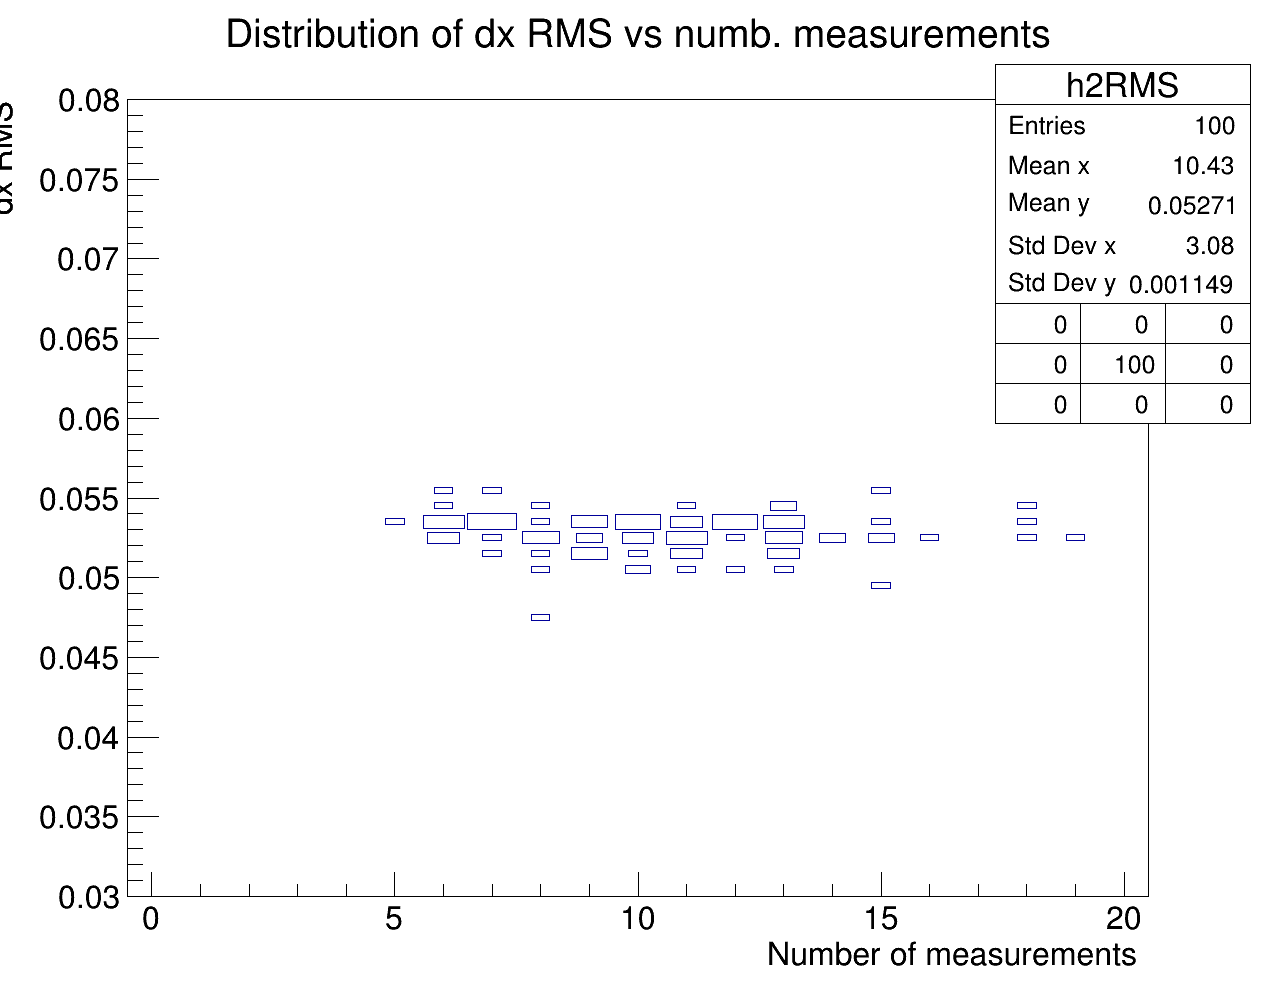

In [15]:
canv.Draw()

As usual we can also store the canvas to a pdf file foir future use

In [16]:
canv.SaveAs("/tmp/2dRMS.pdf");

Info in <TCanvas::Print>: pdf file /tmp/2dRMS.pdf has been created


Now we clear the canvas and divide it to show two histograms side by side

In [17]:
  canv.Clear();
  canv.Divide(1,2);

In the first pad we plot the distribution of # of measurements which was exracted from a Poisson distribution

In [18]:
  canv.cd(1);
  hnmeas.Draw("");

In the second pad we have the distribution of RMS from the experiments

In [19]:
  canv.cd(2);
  hdxRMS.Draw("pe");

Now we draw the canvas for interactive view and save also to file

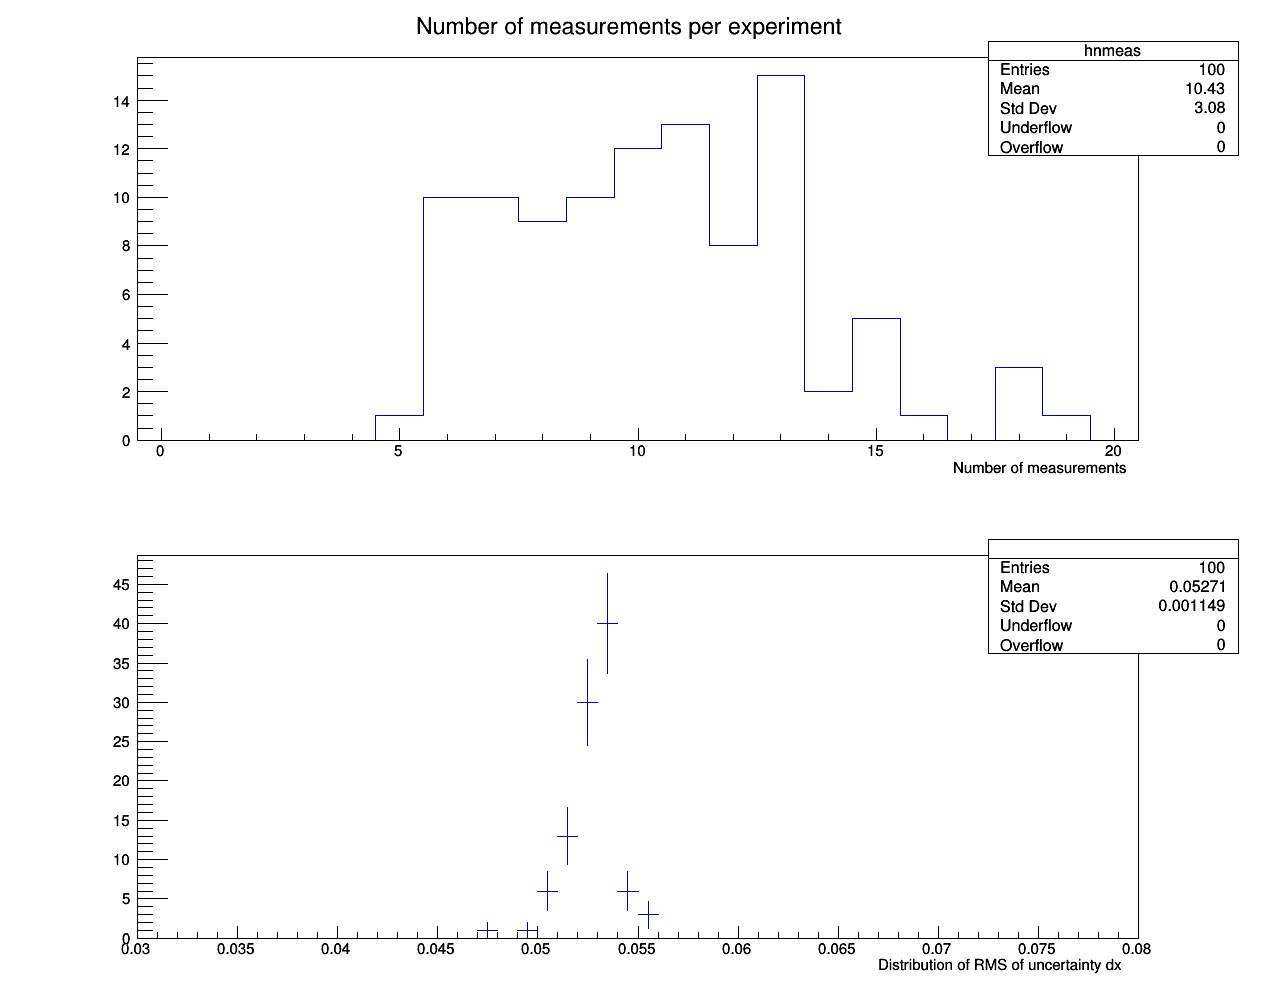

Info in <TCanvas::Print>: pdf file /tmp/expplots.pdf has been created


In [20]:
  canv.Draw();
  canv.SaveAs("/tmp/expplots.pdf");

At the end it's always important to close the file properly to avoid data corruption

In [21]:
  // critical to close the file!
  orootfile->Close();